In [1]:
import json

import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import get_CIFAR10, get_SVHN
from model_eval import Glow

device = torch.device("cuda")

output_folder = 'output/seed_0/'
model_name = 'glow_model_24.pth'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)
    
print(hparams)

image_shape, num_classes, _, test_cifar = get_CIFAR10(hparams['augment'], hparams['dataroot'], hparams['download'])
image_shape, num_classes, _, test_svhn = get_SVHN(hparams['augment'], hparams['dataroot'], hparams['download'])

model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

{'K': 32, 'L': 3, 'LU_decomposed': True, 'actnorm_scale': 1.0, 'augment': True, 'batch_size': 64, 'cuda': True, 'dataroot': './', 'dataset': 'cifar10', 'download': True, 'epochs': 250, 'eval_batch_size': 512, 'flow_coupling': 'affine', 'flow_permutation': 'invconv', 'fresh': False, 'gpuid': 2, 'hidden_channels': 512, 'learn_top': True, 'lr': 0.0005, 'max_grad_clip': 0, 'max_grad_norm': 0, 'n_init_batches': 8, 'n_workers': 6, 'output_dir': 'output/seed_0', 'saved_model': '', 'saved_optimizer': '', 'seed': 0, 'warmup': 5, 'warmup_steps': 4000, 'y_condition': True, 'y_weight': 0.01}
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data/SVHN/train_32x32.mat
Using downloaded and verified file: data/SVHN/test_32x32.mat


In [2]:
def compute_nll(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, nll, _, _ = model(x, y_onehot=y)
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

In [3]:
def compute_logpz(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    logpzs = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, _, _, logpz = model(x, y_onehot=y)
            logpzs.append(logpz)
        
    return torch.cat(logpzs).cpu()

In [5]:
cifar_nll = compute_nll(test_cifar, model)
svhn_nll = compute_nll(test_svhn, model)

print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))

CIFAR NLL tensor(5.2087)
SVHN NLL tensor(4.2800)


In [4]:
cifar_pz = compute_logpz(test_cifar, model)
svhn_pz = compute_logpz(test_svhn, model)

print("CIFAR log p(z)", torch.mean(cifar_pz))
print("SVHN log p(z)", torch.mean(svhn_pz))

CIFAR log p(z) tensor(-1093.2076)
SVHN log p(z) tensor(-1081.9742)


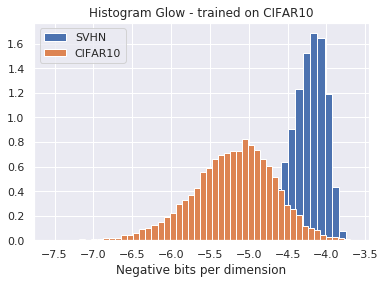

In [6]:
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("Negative bits per dimension")
plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30)
plt.hist(-cifar_nll.numpy(), label="CIFAR10", density=True, bins=50)
plt.legend()
plt.show()

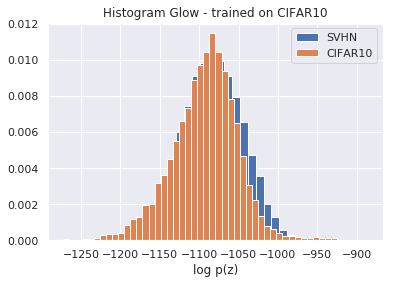

In [6]:
plt.figure()
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("log p(z)")
plt.hist(svhn_pz.numpy(), label="SVHN", density=True, bins=30)
plt.hist(cifar_pz.numpy(), label="CIFAR10", density=True, bins=50)
plt.legend()
plt.show()